In [ ]:
## Import Required Libraries
import os
import openslide
from openslide import open_slide

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob

from sklearn.model_selection import train_test_split

from PIL import Image

In [3]:
# Open with OPENSLIDE to get the full package to handle TIFF / Pyramidal format of filetype
slide = open_slide('images/wsi_ovary.svs')

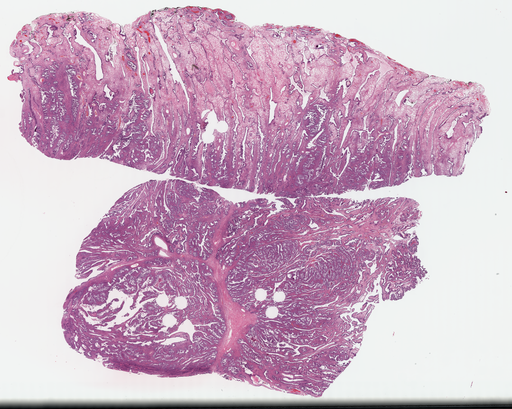

In [ ]:
# preview slide: 
thumb = slide.get_thumbnail((512,512))
thumb

## IMPORT created tiles from slide using HistoClean module

In [5]:
# Path to folder
tile_folder = './images/tiled_images/wsi_ovary'

# Get all image paths (supports png/jpg/jpeg)
image_paths = sorted(glob.glob(os.path.join(tile_folder, '*.png')))  # or '*.jpg'

# Load images
tiles = []
for path in image_paths:
    img = Image.open(path).convert('RGB')  # Convert to 3 channels
    img = img.resize((512, 512))  # optional, if size is inconsistent
    tiles.append(np.array(img))

# Stack into array: shape (N, 512, 512, 3)
X = np.stack(tiles)

X = X.astype(np.float32) / 255.0

In [6]:
print("Shape of X:", X.shape)  # (num_tiles, 512, 512, 3)
print("Type of X:", X.dtype)  # Should be float32

Shape of X: (1306, 512, 512, 3)
Type of X: float32


In [9]:
# 80% train, 20% test
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Type of X_train:", X_train.dtype)  # Should be float32
print("Type of X_test:", X_test.dtype)  # Should be float32

Train shape: (1044, 512, 512, 3)
Test shape: (262, 512, 512, 3)
Type of X_train: float32
Type of X_test: float32


# Build and train the autoencoder

In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

input_shape = (512, 512, 3)

In [ ]:
# --- Encoder ---
inputs = layers.Input(shape=input_shape)

x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D(2, padding='same')(x)# Output: (batch, 256, 256, 32)
# x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D(2, padding='same')(x) 
# x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D(2, padding='same')(x) 
# x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
# x = layers.MaxPooling2D(2, padding='same')(x) 

# Flatten spatial grid into a sequence:
x = layers.Reshape((256 * 256, 32))(x)

# Apply Conv1D across the sequence (optional kernel size = 1 or 3)
x = layers.Conv1D(1, kernel_size=1, activation='linear')(x)  # (batch, 65536, 1)

# Reshape to (256, 256)
latent = layers.Reshape((256, 256))(x)

2025-07-17 11:34:10.422591: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-07-17 11:34:10.423075: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-17 11:34:10.423081: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-07-17 11:34:10.423425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-17 11:34:10.423484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# --- Decoder ---
# Add channel dimension back → (256, 256, 1)
x = Lambda(lambda x: K.expand_dims(x, axis=-1))(latent)

# Restore to 32 filters
x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

# x = layers.Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(x)
# x = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
# x = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)

# Final Output
outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

In [13]:
autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 65536, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 65536, 1)       │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 256, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 512, 512, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 512, 512, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,364 (44.39 KB)

 Trainable params: 11,364 (44.39 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=8, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100


2025-07-17 11:34:36.813290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 188ms/step - loss: 0.6299 - val_loss: 0.5355
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - loss: 0.5314 - val_loss: 0.5300
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - loss: 0.5245 - val_loss: 0.5275
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - loss: 0.5299 - val_loss: 0.5268
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - loss: 0.5246 - val_loss: 0.5266
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 220ms/step - loss: 0.5265 - val_loss: 0.5263
Epoch 7/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - loss: 0.5263 - val_loss: 0.5261
Epoch 8/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 28s 215ms/step - loss: 0.5271 - val_loss: 0.5261
Epoch 9/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - loss: 0.5274 - val_loss: 0.5260
Epoch 10/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 228ms/step - loss: 0.5252 - val_loss: 0.5259
Epoch 11/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 29s 224ms/step - loss: 0.5236 - val_loss: 0.5258
Epoch 12/100
131/131

## Visualise the reconstructions side by side 

In [15]:
def show_reconstructions(model, X_data, n=5):
    """
    Show 'n' original and reconstructed images side-by-side.
    
    Parameters:
        model: trained autoencoder
        X_data: input data, shape (N, 512, 512, 3)
        n: number of images to display
    """
    decoded_imgs = model.predict(X_data[:n])

    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # Original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_data[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


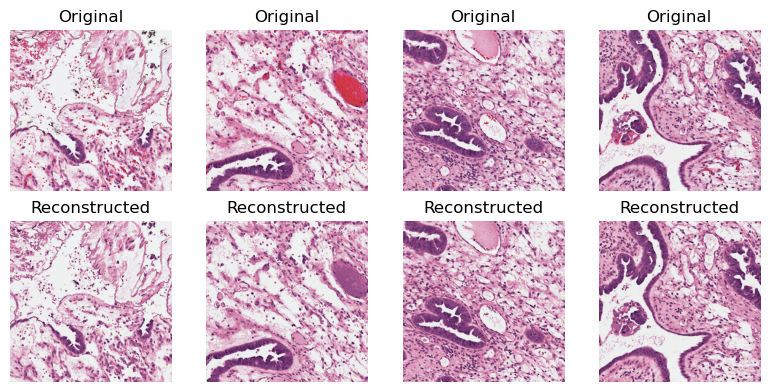

In [16]:
show_reconstructions(autoencoder, X, n=4)

## Save images to disk for size comparison. 

In [17]:
from tensorflow.keras.models import Model

# Suppose this is your encoder model:
encoder = Model(inputs=autoencoder.input, outputs=latent)

# Select an image
sample = X[1:2]  # shape (1, H, W, C)

# Get latent vector
compressed = encoder.predict(sample) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [18]:
sample.shape

(1, 512, 512, 3)

In [19]:
compressed.shape

(1, 256, 256)

In [20]:
np.save('compressed_sample.npy', compressed)

In [21]:
compressed.tofile('compressed_sample.bin')

In [22]:
# Assuming input image is scaled 0-1 and needs converting back to 0–255
img = (sample[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(img).save("original_image.png")

In [23]:
# copy of above make compressed to img ??
comp = (compressed[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(comp).save("compressed_image.png")

In [24]:
decoded = autoencoder.predict(X[1:2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


In [25]:
decoded.shape

(1, 512, 512, 3)

In [26]:
# output image is scaled 0-1 and needs converting back to 0–255
decoded_img = (decoded[0] * 255).astype(np.uint8)

# Save as PNG
Image.fromarray(decoded_img).save("reconstructed_image.png")

In [27]:
import os

original_size = os.path.getsize("original_image.png")
compressed_image_size = os.path.getsize("compressed_image.png")
compressed_size = os.path.getsize("compressed_sample.npy")
compressed_bin = os.path.getsize("compressed_sample.bin")
reconstructed_size = os.path.getsize("reconstructed_image.png")

print(f"Original image size: {original_size / 1024:.2f} KB")
print(f"Compressed image size: {compressed_image_size / 1024:.2f} KB")
print(f"Compressed latent size npy: {compressed_size / 1024:.2f} KB")
print(f"Compressed latent size bin: {compressed_bin / 1024:.2f} KB")
print(f"Reconstructed image size: {reconstructed_size / 1024:.2f} KB")

Original image size: 534.43 KB
Compressed image size: 59.01 KB
Compressed latent size npy: 256.12 KB
Compressed latent size bin: 256.00 KB
Reconstructed image size: 479.79 KB


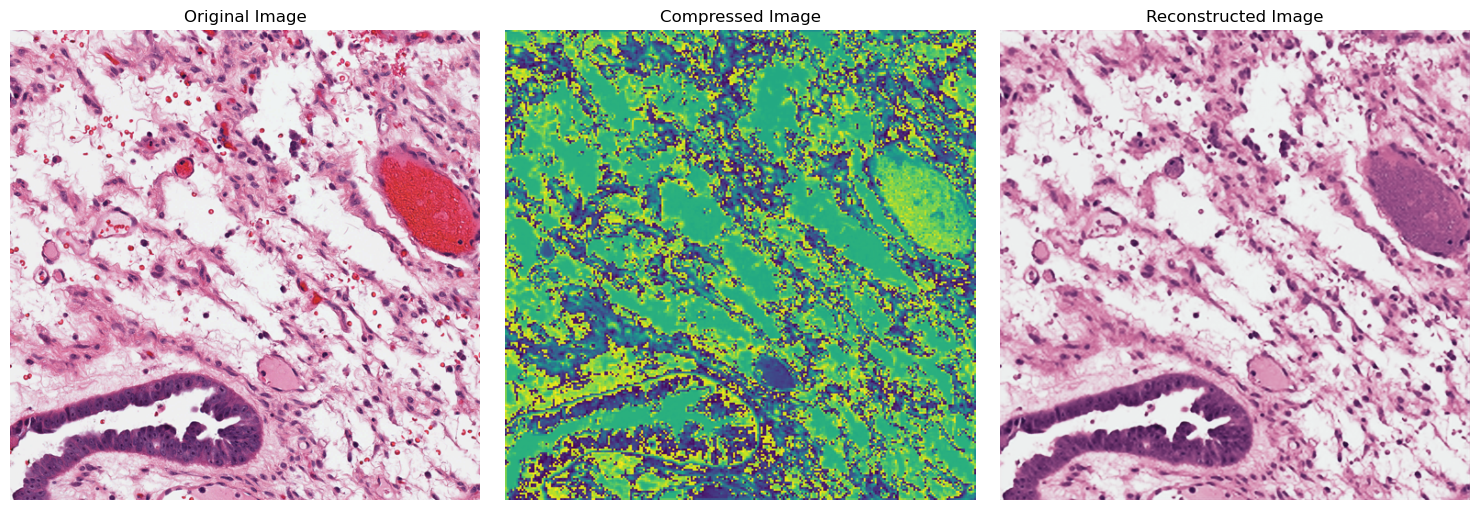

In [28]:
# Load the images
original = Image.open("original_image.png")
compressed = Image.open("compressed_image.png")
reconstructed = Image.open("reconstructed_image.png")

# Get file sizes in KB
# original_size = os.path.getsize("original_image.png") / 1024
# compressed_size = os.path.getsize("compressed_image.png") / 1024
# reconstructed_size = os.path.getsize("reconstructed_image.png") / 1024

# Create side-by-side display
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title(f"Original Image") #\n{original_size:.2f} KB
plt.axis("off")

# Compressed image
plt.subplot(1, 3, 2)
plt.imshow(compressed)
plt.title(f"Compressed Image") #\n{compressed_size:.2f} KB")
plt.axis("off")

# Reconstructed
plt.subplot(1, 3, 3)
plt.imshow(reconstructed)
plt.title(f"Reconstructed Image") #\n{reconstructed_size:.2f} KB")
plt.axis("off")

# Show the plot
plt.tight_layout()
plt.show()

## Extract latent vectors from new WSI_heart files using autoencoder to predict

In [29]:
# Path to folder
tile_folder = './images/tiled_images/wsi_heart'

# Get all image paths (supports png/jpg/jpeg)
image_paths = sorted(glob.glob(os.path.join(tile_folder, '*.png')))  # or '*.jpg'

# Load images
tiles = []
for path in image_paths:
    img = Image.open(path).convert('RGB')  # Convert to 3 channels
    img = img.resize((512, 512))  # optional, if size is inconsistent
    tiles.append(np.array(img))

# Stack into array: shape (N, 512, 512, 3)
Y = np.stack(tiles)

Y = Y.astype(np.float32) / 255.0

In [30]:
print("Shape of Y:", Y.shape)  # (num_tiles, 512, 512, 3)
print("Type of Y:", Y.dtype)  # Should be float32

Shape of Y: (115, 512, 512, 3)
Type of Y: float32


In [ ]:
encoder = models.Model(inputs, latent)
latent_vectors = encoder.predict(Y)  # Shape: (N, 256, 256)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step WARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1669218a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [32]:
latent_flat = latent_vectors.reshape(latent_vectors.shape[0], -1)  # (N, features)

In [33]:
latent_flat.shape

(115, 65536)

# Try to calculate the loss between original vs reconstructed image.

In [34]:
# Binary Crossentropy (BCE) is a loss function that measures the difference between two probability distributions — in our case, the original and reconstructed images interpreted as probabilities per pixel.
from tensorflow.keras.losses import BinaryCrossentropy

# Reconstruct the tiles
reconstructed = autoencoder.predict(Y)

# Define the BCE loss object
bce = BinaryCrossentropy()

# Compute per-image loss
per_image_loss = [bce(Y[i], reconstructed[i]).numpy() for i in range(len(Y))]

# Average loss across all tiles
average_loss = np.mean(per_image_loss)

print(f"BCE Loss for each image: {per_image_loss}\n")
print(f"Average Reconstruction Loss (BCE): {average_loss:.5f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
BCE Loss for each image: [0.34799758, 0.41505, 0.53645265, 0.5659214, 0.5750614, 0.57707506, 0.57859397, 0.5813268, 0.5718267, 0.5125007, 0.34596, 0.50222415, 0.43514788, 0.53886735, 0.5624964, 0.5742982, 0.5533485, 0.5836432, 0.5875325, 0.5835215, 0.5679312, 0.3780146, 0.504067, 0.554415, 0.5110591, 0.3490798, 0.53591746, 0.5550647, 0.5618811, 0.5781164, 0.58386743, 0.5867225, 0.5882547, 0.5809169, 0.516845, 0.54840255, 0.55871046, 0.5556538, 0.5069337, 0.51054573, 0.55500805, 0.5714127, 0.5812062, 0.5867981, 0.58590496, 0.58450687, 0.377805, 0.5420548, 0.5380275, 0.56834733, 0.569565, 0.5488822, 0.5170404, 0.538097, 0.58008295, 0.58429706, 0.58517367, 0.58358145, 0.37864453, 0.53217316, 0.44029295, 0.5189475, 0.38446862, 0.5613275, 0.54072183, 0.5666739, 0.57297873, 0.55997926, 0.54055166, 0.58458996, 0.58236974, 0.5798747, 0.3610384, 0.5175296, 0.5247412, 0.5665396, 0.5603875, 0.56527483, 0.5360668, 0.42345458, 0.3585186, 0.45650882, 0.5727621,

In [35]:
# This is the most common for pixel-wise comparison.
# Calculate per-tile MSE
mse_losses = np.mean((Y - reconstructed) ** 2, axis=(1, 2, 3))  # shape: (N,)

# Calculate overall average MSE - LOWER IS BETTER
average_mse = np.mean(mse_losses)

print(f"MSE Loss for each image: {mse_losses}\n")
print(f"Average Reconstruction Loss (MSE): {average_mse:.5f}")

MSE Loss for each image: [0.0007192  0.0013597  0.00252159 0.00334308 0.00353306 0.00355622
 0.00388806 0.00373244 0.00307063 0.00154016 0.00091782 0.00189295
 0.00139174 0.00246848 0.00343038 0.00369635 0.00310356 0.00386104
 0.00437682 0.00400275 0.00299374 0.00091004 0.00185121 0.00289809
 0.00218633 0.00087561 0.00256871 0.00331802 0.00331792 0.00395869
 0.00385612 0.00432737 0.00442135 0.00365242 0.00200045 0.00267359
 0.00350584 0.00324996 0.00215134 0.00289576 0.00399152 0.00411895
 0.0045225  0.00481234 0.00496898 0.00440876 0.00093681 0.00265505
 0.00292438 0.00388949 0.00377805 0.00297625 0.00225249 0.00395986
 0.00465252 0.00450271 0.00474925 0.00449007 0.00106491 0.00245464
 0.0011182  0.00144802 0.00083269 0.00332208 0.00322731 0.0037358
 0.00385685 0.00325977 0.0025379  0.0043397  0.004542   0.00436785
 0.00092094 0.00227739 0.00258365 0.00315867 0.00335856 0.00299287
 0.00267487 0.00152328 0.00087189 0.00252843 0.00357807 0.00214608
 0.00278305 0.00259106 0.0025603  0.00

In [36]:
# Calculate Structural Similarity Index (SSIM)
ssim_val = tf.image.ssim(Y, reconstructed, max_val=1.0)

# Calculate overall average SSIM - HIGHER IS BETTER
average_ssim = np.mean(ssim_val)

print(f"SSIM Loss for each image: {ssim_val}\n")
print(f"Average SSIM Loss: {average_ssim:.5f}")

SSIM Loss for each image: [0.8092518  0.76440597 0.699557   0.6825375  0.6786228  0.6704278
 0.6789873  0.67181    0.6696148  0.7082992  0.81718063 0.7102693
 0.7520601  0.69920117 0.67690283 0.6666342  0.70749635 0.6700349
 0.66492224 0.67582613 0.6829631  0.80436605 0.7026911  0.6780288
 0.7035126  0.82754564 0.69681007 0.6998027  0.6931839  0.6643416
 0.66761136 0.6650348  0.64802736 0.66661406 0.71415204 0.6879175
 0.67490417 0.6786     0.7016466  0.71807146 0.6938934  0.6764048
 0.66855097 0.6467274  0.66117793 0.6496005  0.803971   0.6959083
 0.7096176  0.66095    0.6658572  0.68341523 0.6818145  0.6990347
 0.6697095  0.6673456  0.6671211  0.6541573  0.8111317  0.72261745
 0.75518584 0.69838077 0.79149014 0.66614884 0.69684047 0.67431384
 0.66219944 0.67853904 0.67791265 0.66539973 0.68398446 0.67377967
 0.81851083 0.720197   0.70920295 0.6674082  0.67635685 0.67193264
 0.69929504 0.78972244 0.80661726 0.7666295  0.67652375 0.6909383
 0.69277906 0.7243538  0.70233685 0.70350224 0

In [37]:
# Calculate Peak Signal-to-noise Ratio (PSNR)
psnr_val = tf.image.psnr(Y, reconstructed, max_val=1.0)

# Calculate overall average PSNR - Up to 50. HIGHER IS BETTER
average_psnr = np.mean(psnr_val)

print(f"PSNR Loss for each image: {psnr_val}\n")
print(f"Average PSNR Loss: {average_psnr:.5f}")

PSNR Loss for each image: [31.431517 28.665554 25.983252 24.758528 24.518492 24.490108 24.102673
 24.280067 25.127722 28.124342 30.372416 27.228605 28.564413 26.075699
 24.64658  24.322268 25.081402 24.13296  23.58841  23.97642  25.237864
 30.409374 27.32544  25.378885 26.602837 30.57689  25.902845 24.791208
 24.791336 24.024487 24.138496 23.637758 23.544447 24.374187 26.988731
 25.72906  24.552076 24.881224 26.67291  25.38237  23.988615 23.85213
 23.446209 23.176434 23.037327 23.556835 30.283463 25.759266 25.339663
 24.101072 24.227316 25.263296 26.473368 24.023203 23.32311  23.465261
 23.233747 23.477468 29.726881 26.100119 29.514797 28.392239 30.79516
 24.785894 24.911589 24.276157 24.13767  24.868122 25.95525  23.625404
 23.427528 23.597319 30.357687 26.425629 25.877665 25.00496  24.738476
 25.239117 25.726965 28.172197 30.595406 25.971493 24.463514 26.683542
 25.554789 25.86523  25.917088 26.312849 26.97495  28.075712 26.122543
 25.641823 26.012806 30.099154 28.878325 28.234154 28

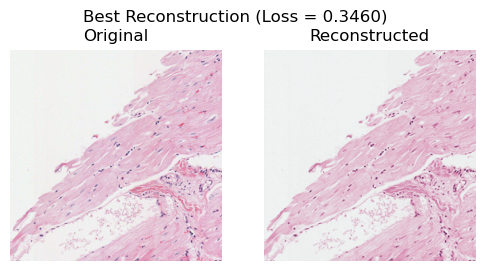

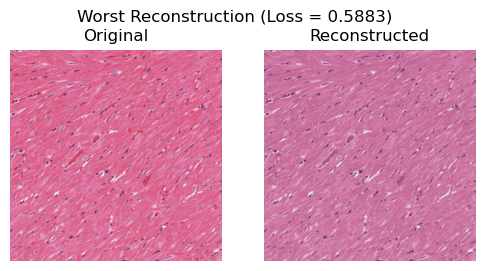

In [ ]:
# Show best and worst ... REALLY INTERESTING! 

# Get indices of best and worst
best_idx = np.argmin(per_image_loss)
worst_idx = np.argmax(per_image_loss)

def show_tile_comparison(index, title):
    plt.figure(figsize=(6, 3))
    plt.suptitle(title)

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(Y[index])
    plt.title("Original")
    plt.axis("off")

    # Reconstruction
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed[index])
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

show_tile_comparison(best_idx, f"Best Reconstruction (Loss = {per_image_loss[best_idx]:.4f})")
show_tile_comparison(worst_idx, f"Worst Reconstruction (Loss = {per_image_loss[worst_idx]:.4f})")

In [39]:
original_image = Y[0]
print("ORIGINAL IMAGE - Shape: ", original_image.shape, ", Size: ", original_image.size)

latent_vector = latent_vectors[0]
print("LATENT VECTOR - Shape: ", latent_vector.shape, ", Size: ", latent_vector.size)

# Percentage compression achieved.
compression_percentages = []

for original_image, latent_vector in zip(Y, latent_vectors):
    original_size = original_image.size
    latent_size = latent_vector.size
    # Calc percent for each tile
    percent = (1 - (latent_size / original_size)) * 100
    compression_percentages.append(percent)

average_compression = np.mean(compression_percentages)
print("Average compression across all tiles: {:.2f}%".format(average_compression))

ORIGINAL IMAGE - Shape:  (512, 512, 3) , Size:  786432
LATENT VECTOR - Shape:  (256, 256) , Size:  65536
Average compression across all tiles: 91.67%
